<a href="https://colab.research.google.com/github/Tstrebe2/umich-mads-capstone-project/blob/tim-branch/tim-playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import sys

!{sys.executable} -m pip install pydicom -q

     |████████████████████████████████| 2.0 MB 4.2 MB/s 


In [1]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/capstone/assets/stage_2_train_images.zip'

!unzip {path}

In [18]:
# source code: https://medium.com/@vivek8981/dicom-to-jpg-and-extract-all-patients-information-using-python-5e6dd1f1a07d
import pydicom as dicom
import os
import cv2
import PIL # optional

folder_path = "/content"
images_paths = os.listdir(folder_path)[1:9]

ds = dicom.dcmread(os.path.join(folder_path, images_paths[0]))

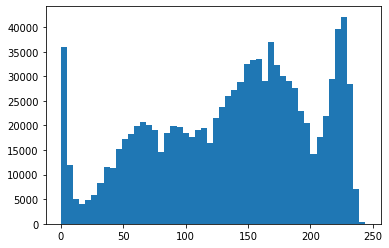

In [26]:
import matplotlib.pyplot as plt

plt.hist(ds.pixel_array.ravel(), bins=50)
plt.show()

In [32]:
import torchvision
import torch

class LeNet(torch.nn.Module):
  def __init__(self, num_channels, classes):
    super(LeNet, self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=num_channels, out_channels=20, kernel_size=20)
    self.relu1 = torch.nn.Relu()
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    self.conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
    self.relu2 = torch.nn.Relu()
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    # initialize first (and only) set of FC => RELU layers
    self.fc1 = torch.nn.Linear(in_features=800, out_features=500)
    self.relu3 = torch.nn.ReLU()
    # initialize our softmax classifier
    self.fc2 = torch.nn.Linear(in_features=500, out_features=classes)
    self.logSoftmax = torch.nn.LogSoftmax(dim=1)

  def forward(self, x):
    # pass the input through our first set of CONV => RELU =>
    # POOL layers
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)
    # pass the output from the previous layer through the second
    # set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)
    # flatten the output from the previous layer and pass it
    # through our only set of FC => RELU layers
    x = torch.nn.flatten(x, 1)
    x = self.fc1(x)
    x = self.relu3(x)
    # pass the output to our softmax classifier to get our output
    # predictions
    x = self.fc2(x)
    output = self.logSoftmax(x)
    # return the output predictions
    return output


In [35]:
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.optim import Adam
from torch import nn

import matplotlib.pyplot as plt
import numpy as np
import time

In [45]:
init_learning_rate = 1e-3
batch_size = 64
epochs = 10

train_split = .25
val_split = 1-train_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, indices=None, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = ''.join([os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]), '.dcm'])
    
    image = dicom.dcmread(os.path.join(folder_path, img_path))
    image = image.pixel_array

    label = self.img_labels.iloc[idx, -1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

In [133]:
from sklearn.model_selection import train_test_split

annotations_file = '/content/drive/MyDrive/capstone/assets/stage_2_train_labels.csv.zip'
img_dir = '/content'

label_df = pd.read_csv(annotations_file)

X_train, X_test = train_test_split(label_df, test_size=.1, stratify=label_df.Target)
X_train, X_val, = train_test_split(X_train, test_size=.25, stratify=X_train.Target)
X_train, X_test, X_val = X_train.index, X_test.index, X_val.index

In [147]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5547, 0.1781),
    torchvision.transforms.RandomHorizontalFlip(.1),
    torchvision.transforms.RandomRotation(degrees=(-7, 7))
])

dataset = CustomImageDataset(annotations_file, img_dir, transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)



tensor([[ 0.0000,  0.0000, -3.0925,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -3.0925,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -3.0925,  ..., -3.0485, -3.0485, -3.0705],
        ...,
        [-2.3879, -2.3439, -2.3439,  ..., -3.0925,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -3.0925,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -3.0925,  0.0000,  0.0000]])

TypeError: ignored